In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow import keras
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Data/')
from analysis_util import *

In [ ]:
# with open('../data/resize/X_80.pkl', 'rb') as fp:
#     X_80 = pickle.load(fp)
# with open('../data/resize/y.pkl', 'rb') as fp:
#     y = pickle.load(fp)

In [8]:
with open('/content/drive/My Drive/Data/padded/X_padded_80.pkl', 'rb') as fp:
  X_80 = pickle.load(fp)

with open('/content/drive/My Drive/Data/resize/y.pkl', 'rb') as fp:
  y_classes = pickle.load(fp)

In [9]:
y = np.array(pd.get_dummies(y_classes))

In [10]:
classes = get_classes(y)
cw = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classes), classes)))

In [11]:
X_80_train, X_80_test, y_train, y_test = train_test_split(X_80, y, test_size=int(len(y)*.15), random_state=42)
X_80_train, X_80_val, y_train, y_val = train_test_split(X_80_train, y_train, test_size=int(len(y)*.15), random_state=42)

In [ ]:
print(len(X_80_train))
print(len(X_80_val))
print(len(X_80_test))

In [ ]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

In [ ]:
model = keras.models.Sequential()

#Define the input size and rescale all values to be between 0 and 1.
model.add(keras.layers.Input((80,80,1)))
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255))

#A convolutional block
model.add(keras.layers.Convolution2D(32, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Convolution2D(64, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Convolution2D(128, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Convolution2D(256, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# Flatten the last convolutional layer output and connect to 2 fully connected layers and a final output layer (514 classes).
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(5000))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(1000))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(514, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(
    np.asarray([np.asarray(x) for x in X_80_train]).reshape(-1,80,80,1), 
    np.array(y_train), 
    epochs=10, 
    batch_size=512, 
    # class_weight=cw,
    validation_data=(np.asarray([np.asarray(x) for x in X_80_val]).reshape(-1,80,80,1).reshape(-1,80,80,1), y_val))

In [ ]:
visualize_training_results(history)

In [ ]:
# plt.figure(figsize=(20,16))
# sns.heatmap(
#     confusion_matrix(
#         get_classes(y_test), 
#         get_classes(model.predict(np.array(X_80_test).reshape(-1,80,80,1))), 
#         normalize='true'
#     )
# )

In [ ]:
## custom classification report

In [ ]:
pd.Series(classes).value_counts(normalize=True)

In [ ]:
yhat_test = get_classes(model.predict(np.array([np.asarray(x) for x in X_80_test]).reshape(-1,80,80,1)))
dummy_to_unicode = dict(enumerate(pd.get_dummies(y_classes).columns))

In [ ]:
print(classification_report(get_classes(y_test), yhat_test))

In [ ]:
misclassifications = misclass_report(get_classes(y_test), yhat_test, dummy_to_unicode)

In [ ]:
index=451
print(chr(int(dummy_to_unicode[index][2:], 16)))
# print(513)
misclassifications[index]

In [ ]:
model.save('/content/drive/My Drive/Models/cnn_baseline')

In [4]:
model = keras.models.load_model('/content/drive/My Drive/Models/cnn_baseline')

In [5]:
layer_outputs = [layer.output for layer in model.layers]

In [21]:
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs[:12])

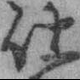

In [65]:
X_80_test[200]

In [66]:
activations = activation_model.predict(np.asarray(X_80_test[200]).reshape(80,80,1))

In [67]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

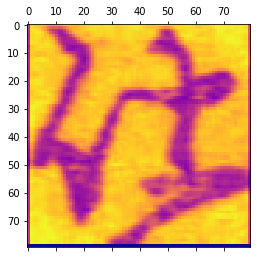

In [68]:
plt.matshow(activations[1][:, :, 0, 10], cmap='plasma')

In [77]:
sns.set_style('white')

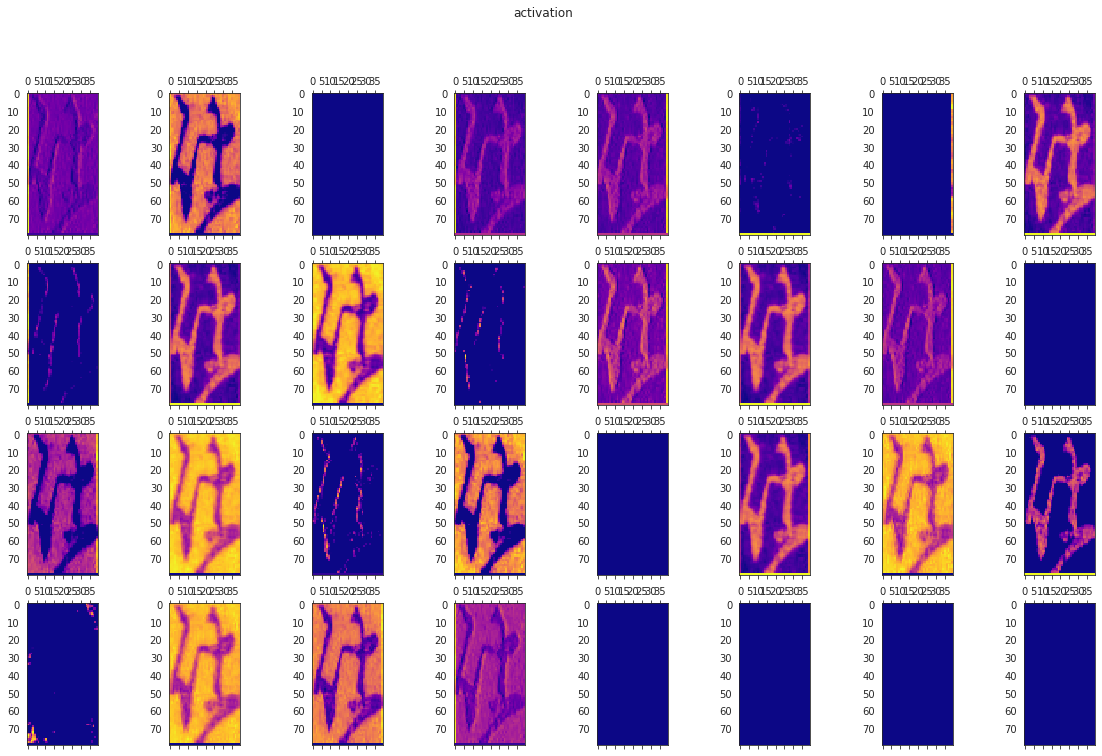

In [80]:
#First layer activations
fig, axes = plt.subplots(4, 8, figsize=(20, 12))
fig.suptitle(layer_names[4])
for i in range(32):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.matshow(activations[4][:, :, 0, i], cmap='plasma')

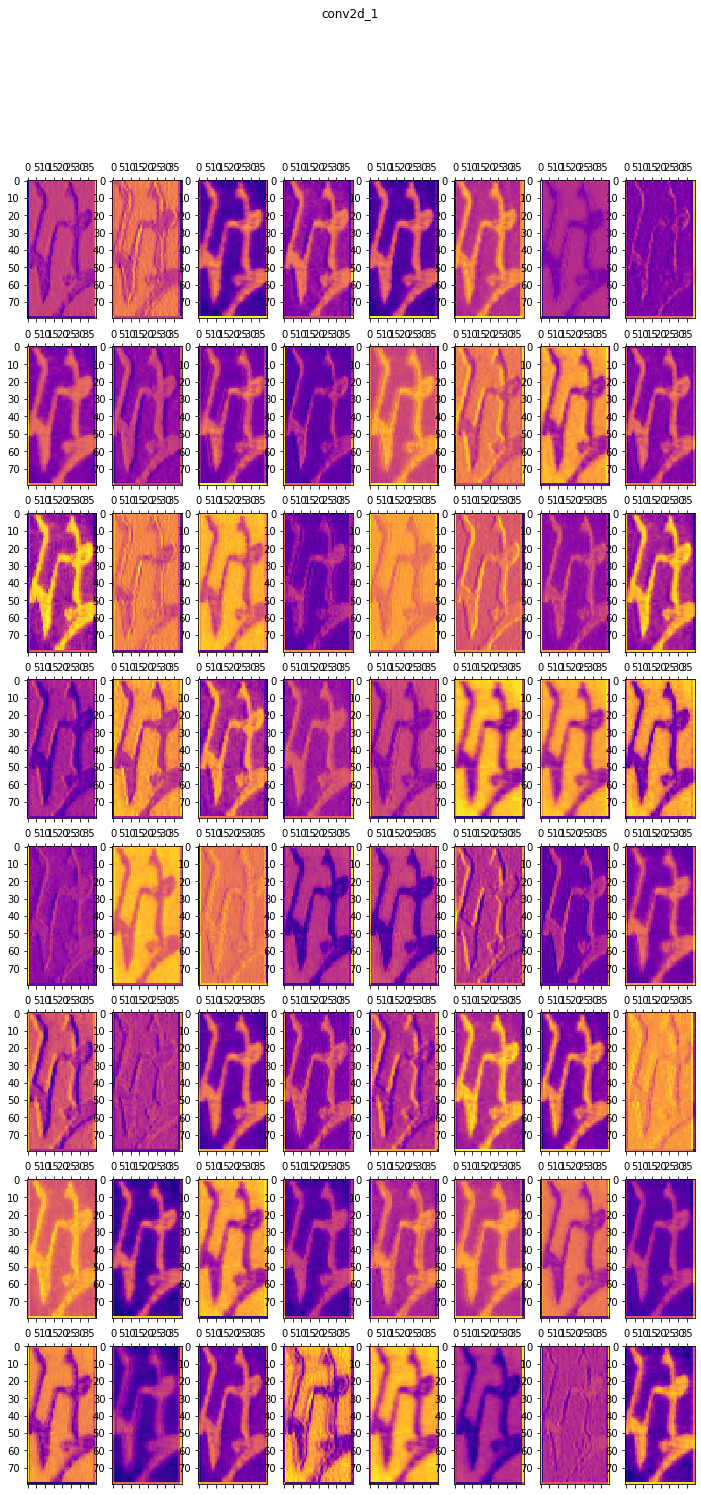

In [70]:
#Second layer activations
fig, axes = plt.subplots(8, 8, figsize=(12,24))
fig.suptitle(layer_names[5])
for i in range(64):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.matshow(activations[5][:, :, 0, i], cmap='plasma')

In [61]:
activations[-11].shape

(80, 80, 1, 32)

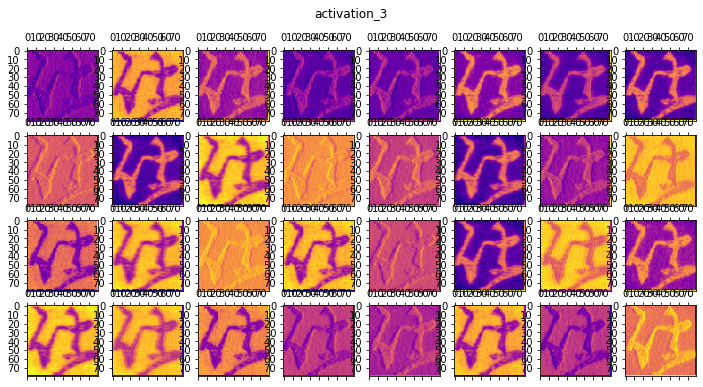

In [71]:
#Final conv layer activations
fig, axes = plt.subplots(4, 8, figsize=(12,6))
fig.suptitle(layer_names[-11])
for i in range(32):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.matshow(activations[-11][:, :, 0, i], cmap='plasma')

In [40]:
layer_names

['rescaling',
 'conv2d',
 'max_pooling2d',
 'batch_normalization',
 'activation',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'activation_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'activation_2',
 'conv2d_3',
 'max_pooling2d_3',
 'batch_normalization_3',
 'activation_3',
 'flatten',
 'dense',
 'batch_normalization_4',
 'activation_4',
 'dropout',
 'dense_1',
 'batch_normalization_5',
 'activation_5',
 'dropout_1',
 'dense_2']

In [ ]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')